###  ICLR COMPETITION : Transfer learning 

- This is to build deep learning architecture for classifying the state of wheat conditions. 

- This is to use google colab for eveluation

In [0]:
### import the packages needed 
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 
import torch 
from torchvision import datasets, transforms
import warnings
warnings.filterwarnings("ignore")
import cv2 
from PIL import Image
from torchvision import models
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
## using the glob package. 
import os
import glob
image_files = glob.glob('drive/My Drive/ICLR_Competition/Data/train/*')
### check the ectension of the data. 
extensions = set()
for im_file in image_files:
    _, ext = os.path.splitext(im_file)
    extensions.add(ext)

###  Data augmentation


The images in the available training set can be modified in a number of ways to incorporate more variations in the training process, so that the trained model gets more generalized and performs well on different kinds of test data. Also the input data can come in a variety of sizes. They need to be normalized to a fixed size and format before batches of data are used together for training.

Each of the input images are first passed through a number of transformations. We try to insert some variations by introducing some randomness into the transformations. In each epoch, a single set of transformations are applied to each image. When we train for multiple epochs, the models gets to see more variations of the input images with a new randomized variation of the transformation in each epoch. This results in data augmentation and the model then tries to generalize more.

#### Restructure the images:

- Resize the images into 224 $\times$ 224 in order to suit the pretrained models. 

####  Loading the dataset:

- The datasets for train and test is loaeded 

In [7]:
# Coding: utf-8
import os
import glob 
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.utils.data.dataloader 
from torchvision import datasets, transforms


#train_path = "Data/train"
#test_path = "Data/test"


### The function to obtain the mean and standard deviation of the images 

###### The entire mean and standard deviation of the images.
#[0.45615122 0.47518504 0.3208348 ]
#[0.21813191 0.20548095 0.20645605]


def mean_stdev():

  """
  Operation:
          Estimate the mean and standard deviation of images 
  return:
        return the values for mean and deviation
  """


  Transform = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor()
  ])

  data = datasets.ImageFolder("drive/My Drive/ICLR_Competition/Data/train",transform=Transform)
  dataloader = torch.utils.data.DataLoader(data,batch_size=64, shuffle=False)

  data_mean = [] # Mean of the dataset
  data_std0 = [] # std of dataset
  for images,labels in dataloader:

      # shape (batch_size, 3, height, width)
      numpy_image = np.array(images)

      # shape (3,)
      batch_mean = numpy_image.mean(axis=(0,2,3))
      batch_std0 = numpy_image.std(axis=(0,2,3))

      data_mean.append(batch_mean)
      data_std0.append(batch_std0)

  # shape (num_iterations, 3) -> (mean across 0th axis) -> shape (3,)
  data_mean = np.array(data_mean).mean(axis=0)
  data_std0 = np.array(data_std0).mean(axis=0)

  """
  Return:
      return the mean and standard deviation.
  """
  return data_mean , data_std0





class Load_data(object):
    '''
    Load the images for both train and test sets 
    '''
    def __init__(self,train_path="drive/My Drive/ICLR_Competition/Data/train",test_path="drive/My Drive/ICLR_Competition/Data/valid",train_size=32,test_size=1,mean=None,std=None):
        '''
        Arge:
            train_size: the batch_size for the training 
            test_size : the test_size for testing 
            mean: array of input for normalizing 
            std: array of numbers for the standard deviation.
        '''
        self.train_path = train_path
        self.test_path = test_path
        self.train_size = train_size
        self.test_size = test_size
        self.mean = mean 
        self.std = std 

    def traintset(self):

        '''
        Return:
            batch of datasets using the dataloader 
        '''
        Transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(45),
            transforms.ToTensor(),
            transforms.Normalize(self.mean,self.std)
        ])
        trainsets = datasets.ImageFolder(self.train_path,transform=Transforms)

        """
        Return:
            train datasets for a batch.
        """
        return torch.utils.data.DataLoader(trainsets,batch_size=self.train_size,shuffle=True)
    
    def testset(self):
        
        '''
        Return:
            batch of the testsets from dataloader. 
        '''
        Transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(self.mean,self.std)
        ])

        testsets = datasets.ImageFolder(self.test_path,transform= Transforms)

        """
        Return:
            Batch of test set for testing 
        """

        return torch.utils.data.DataLoader(testsets,batch_size=self.train_size,shuffle=False)


if __name__ == "__main__":
  #### load the dataset 
  train_dir = "drive/My Drive/ICLR_Competition/Data/train"
  test_dir = "drive/My Drive/ICLR_Competition/Data/valid"
  data_mean , data_std0 = mean_stdev()
  print(data_mean)
  print(data_std0)

  train_size = 32
  test_size = 32
  mean =  data_mean
  std = data_std0  ###
  Loader = Load_data(train_path=train_dir,test_path = test_dir,train_size=train_size,
                                test_size=test_size,mean=mean,std=std)


[0.45619762 0.4752322  0.32088345]
[0.21826732 0.20553656 0.2065898 ]


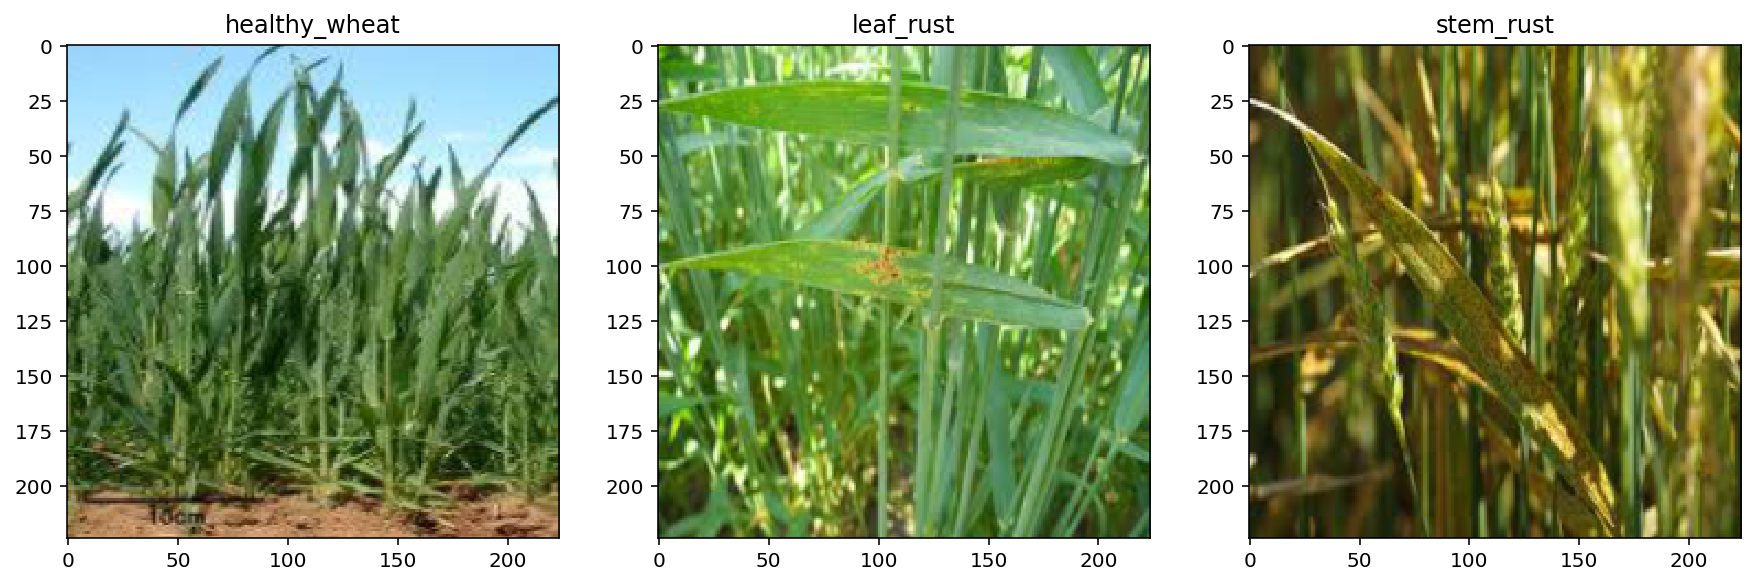

In [9]:
#### visualize the image 
from glob import glob 
plt.figure(1, figsize = (15 , 7))
plt.subplot(1 , 3 , 1)
img = glob("drive/My Drive/ICLR_Competition/Data/train/healthy_wheat/*.jpg") #Getting an image in the healthy wheat folder 
img = Image.open(img[0])
img = Transform(img)
plt.imshow(img.permute(1,2,0))
plt.title("healthy_wheat")

plt.subplot(1 , 3 , 2)
img = glob("drive/My Drive/ICLR_Competition/Data/train/leaf_rust/*.jpg") #Getting an image in the leaf rust folder 
img = Image.open(img[0])
img = Transform(img)
plt.imshow(img.permute(1,2,0))
plt.title("leaf_rust")


plt.subplot(1 , 3 , 3)
img = glob("drive/My Drive/ICLR_Competition/Data/train/stem_rust/*.jpg") #Getting an image in the stem rust folder
img = Image.open(img[0])
img = Transform(img)
plt.imshow(img.permute(1,2,0))
plt.title("stem_rust")
plt.show()

In [0]:
train = Loader.traintset()
valid_set = Loader.testset()

In [11]:
### The number of testing set 
print(len(valid_set.dataset))

135


In [0]:
#### images and labels. 
images,labels = next(iter(train))

In [0]:
Classes = train.dataset.classes

In [14]:
Classes

['healthy_wheat', 'leaf_rust', 'stem_rust']

## Model Implementation. 

- In this section, we tend to implement various pretrained models in torchvision package to train our datasets. This option was chosen because the size of the datasets is small.

- Implement another model from scratch to evaluate the performance of model compare to the pretrained models. 

### Pretrained model: Transfer learning 

Transfer Learning

It is very hard and time consuming to collect images belonging to a domain of interest and train a classifier from scratch. So, we use a pre-trained model as our base and change the last few layers so that we can classify images according to our desirable classes. This helps us get good results even with a small dataset, since the basic image features have already been learnt in the pre-trained model from a much larger dataset like **VGG-16**.

In [15]:
model_1 = models.vgg16(pretrained=True)
model_1

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### VGG-16 architecture 

- In this scenario, we tend to use VGG-16 architecture for the datasets, since the amount of datasets are smalll in number. 

In [0]:
#### Now we have to freeze the parameters in the model so we don't backpropagate through them. 
for param in model_1.parameters():
    param.requires_grad = False 
    
### restructure the the classifier component to suit the data 
from collections import OrderedDict
from torch import nn


### We use the sequential model. 
Classifier = nn.Sequential(OrderedDict([
    ("fc1",nn.Linear(in_features=25088,out_features=2000)),
    ("dropout",nn.Dropout2d(p=0.2)),
    ("fc2",nn.Linear(in_features=2000,out_features=3)),
    ("output",nn.LogSoftmax(dim=1))
]))


### Assign the classifier to the classifier component in the model. 
model_1.classifier = Classifier

In [26]:
sum([param.nelement() for param in model_1.parameters()])

64898691

In [0]:
model_2 = models.AlexNet(num_classes=3)
model_2

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### AlexNet architecture 

- Implemention with AlexNet. 

In [0]:
#### Now we have to freeze the parameters in the model so we don't backpropagate through them. 
for param in model_2.parameters():
    param.requires_grad = False 
    
### restructure the the classifier component to suit the data 
from collections import OrderedDict
from torch import nn

### We use the sequential model. 
Classifier = nn.Sequential(OrderedDict([
    #("Dropout",nn.Dropout(p=0.2)),
    ("fc1",nn.Linear(in_features=9216,out_features=3)),
    # ("relu",nn.ReLU()),
    # ("Dropout",nn.Dropout(p=0.2)),
    # ("fc2",nn.Linear(in_features=4096,out_features=3)),
    ("output",nn.LogSoftmax(dim=1))
]))


### Assign the classifier to the classifier component in the model. 
model_2.classifier = Classifier

In [0]:
### Check the total number of parameters in the model 
sum([param.nelement() for param in model_2.parameters()])

2497347

In [0]:
### For the classifier components. 
sum([param.nelement() for param in model.classifier.parameters()])

123642856

In [0]:
### Check the total number of parameters in the model 
sum([param.nelement() for param in model.parameters()])

14789955

In [0]:
### For the classifier components. 
sum([param.nelement() for param in model.classifier.parameters()])

75267

In [29]:
device = "cuda:0"
model_1.to(device)
#model_1.to(device)
#model_1 = model_3.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Define a training loop 

- We need to define a training loop for the model 

In [31]:
###### Training loop for the model 
from torch import optim
criterion = nn.NLLLoss()
Optim = optim.SGD(model_1.classifier.parameters(),lr=0.001)

epochs = 30
Train_loss = []
Valid_loss = []
for epoch in range(epochs):
    train_loss,val_loss, train_acc,valid_acc= 0,0,0,0
    model_1.train()
    for images,labels in train:
        ### pred the image 
        images = images.to(device)
        labels = labels.to(device)
        pred = model_1(images)
        loss = criterion(pred,labels)
        train_loss += loss.detach().item()
        predss = pred.detach()
        train_acc += predss.argmax(dim=1).eq(labels).sum().item()
        Optim.zero_grad()
        loss.backward()
        Optim.step()
    Train_loss.append(train_loss)

    with torch.no_grad():
        model_1.eval()
        for imgs, labs in valid_set:
            imgs = imgs.to(device)
            labs = labs.to(device) 
            preds = model_1(imgs)
            loss = criterion(preds,labs)
            val_loss += loss.detach().item()
            preds = preds.detach()
            valid_acc += preds.argmax(dim=1).sum().item()
        Valid_loss.append(val_loss)
    print(f"Epoch: {epoch+1}/{epochs} | train loss: {train_loss/len(train):.3f} | validation loss: {val_loss/len(valid_set):.3f}")
    print(f"Epoch: {epoch+1}/{epochs} | train accuracy: {train_acc/len(train):.3f} | validation accuracy: {valid_acc/len(valid_set):.3f}")  


Epoch: 1/30 | train loss: 1.001 | validation loss: 0.898
Epoch: 1/30 | train accuracy: 13.708 | validation accuracy: 45.600
Epoch: 2/30 | train loss: 0.911 | validation loss: 0.895
Epoch: 2/30 | train accuracy: 17.250 | validation accuracy: 36.400
Epoch: 3/30 | train loss: 0.852 | validation loss: 0.867
Epoch: 3/30 | train accuracy: 19.583 | validation accuracy: 32.200
Epoch: 4/30 | train loss: 0.791 | validation loss: 0.880
Epoch: 4/30 | train accuracy: 19.750 | validation accuracy: 31.800
Epoch: 5/30 | train loss: 0.783 | validation loss: 0.788
Epoch: 5/30 | train accuracy: 20.167 | validation accuracy: 33.400
Epoch: 6/30 | train loss: 0.753 | validation loss: 0.769
Epoch: 6/30 | train accuracy: 20.458 | validation accuracy: 32.800
Epoch: 7/30 | train loss: 0.747 | validation loss: 0.803
Epoch: 7/30 | train accuracy: 21.125 | validation accuracy: 31.000
Epoch: 8/30 | train loss: 0.734 | validation loss: 0.777
Epoch: 8/30 | train accuracy: 21.125 | validation accuracy: 33.400
Epoch: 9

In [0]:
submission = pd.read_csv('drive/My Drive/ICLR_Competition/sample_submission.csv')

In [33]:
submission.head()

,ID,leaf_rust,stem_rust,healthy_wheat
0,643083,0,0,0
1,008FWT,0,0,0
2,00AQXY,0,0,0
3,01OJZX,0,0,0
4,07OXKK,0,0,0


In [0]:
Transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])


In [0]:
imgs = glob("drive/My Drive/ICLR_Competition/Data/test/Data/*.JPG")

In [36]:
len(imgs)

175

In [0]:
Imgs = glob("drive/My Drive/ICLR_Competition/Data/test/Data/*.jpg")

In [38]:
len(Imgs)

435

In [0]:
predictions = []


for index, row in submission.iterrows():
    if os.path.exists(os.path.join('drive/My Drive/ICLR_Competition/Data/test/Data/', row['ID']+'.jpg')):
        image = Image.open(os.path.join('drive/My Drive/ICLR_Competition/Data/test/Data/', row['ID']+'.jpg'))
    else:
        image = Image.open(os.path.join('drive/My Drive/ICLR_Competition/Data/test/Data/', row['ID']+'.JPG'))
    image = Transforms(image)
    image = image.to(device)
    p = model_1(image.unsqueeze(0))
    predictions.append(p.detach().cpu().numpy().reshape(-1,))
    

In [0]:
predictions = np.array(predictions)
softmax = nn.Softmax()

In [0]:
predictions = softmax(torch.from_numpy(predictions)).numpy()

In [42]:
print(predictions)

[[0.1823555  0.5733149  0.24432969]
 [0.09267576 0.25837857 0.6489457 ]
 [0.08312617 0.23953071 0.67734313]
 ...
 [0.01934226 0.5149829  0.46567485]
 [0.01264667 0.12195439 0.86539894]
 [0.1599541  0.31907272 0.5209731 ]]


In [0]:
max_predictions = np.argmax(predictions, axis=-1)

In [0]:
submission_pred = np.zeros_like(predictions, dtype=np.uint8)

In [0]:
#for i in range(len(max_predictions)):
#    submission_pred[i, max_predictions[i]] = 1

In [0]:
#submission_pred

In [0]:
out_df = pd.DataFrame(dict(ID=submission['ID'].values, leaf_rust=predictions[:, 0], \
                           stem_rust= predictions[:, 1], healthy_wheat=predictions[:, 2]))

In [47]:
out_df.head()

,ID,leaf_rust,stem_rust,healthy_wheat
0,643083,0.182355,0.573315,0.244330
1,008FWT,0.092676,0.258379,0.648946
2,00AQXY,0.083126,0.239531,0.677343
3,01OJZX,0.092676,0.258379,0.648946
4,07OXKK,0.476515,0.265421,0.258064


In [0]:
out_df.iloc[::-1,:]

,ID,leaf_rust,stem_rust,healthy_wheat
609,ZTWSDG,0.031208,0.863002,0.105790
608,ZSZMOS,0.032935,0.430102,0.536963
607,ZOXDKA,0.155063,0.266246,0.578691
606,ZMAB3R,0.007668,0.941645,0.050686
605,ZKF0L9,0.248761,0.607240,0.143998
...,...,...,...,...
4,07OXKK,0.244631,0.701015,0.054354
3,01OJZX,0.185515,0.465553,0.348932
2,00AQXY,0.004607,0.567793,0.427600
1,008FWT,0.127005,0.468882,0.404113


In [0]:
out_df.to_csv('drive/My Drive/ICLR_Competition/sixth_submission.csv',index=False)